In [147]:
import numpy as np
import math
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

class SAnnealing(object):

    def __init__(self, domain, step = 1, final_temperature=0.1, temperature = 100, alpha=0.95, equilibrium=10, time = 0):
        self.domain = domain
        self.step = step
        self.temperature = temperature
        self.final_temperature = final_temperature
        self.alpha = alpha
        self.equilibrium = equilibrium
        self.time = time

    def ieee_mantissa_to_decimal(self, mantissa_bits, exponent_bias):
        """
        Convierte la mantissa en formato IEEE-754 a su valor decimal.
        """
        sign = -1 if mantissa_bits[0] else 1
        exponent = int(''.join(str(bit) for bit in mantissa_bits[1:exponent_bias+1]), 2) - (2 ** (exponent_bias-1) - 1)
        fraction = 1 + sum(mantissa_bits[exponent_bias+1+i] * 2**(-i-1) for i in range(len(mantissa_bits)-(exponent_bias+1)))
        return sign * fraction * 2**exponent


    def cost_function(self, f, x):
        newX = ieee_mantissa_to_decimal(x,8)
        return f(newX)


    def create_first_solution(self):
        #return np.array([float(np.random.randint(self.domain[i][0], self.domain[i][1])) for i in range(len(self.domain))])
         return np.array([0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])


    def create_neighbor_solution(self, actual_solution):
        neighbor = actual_solution.copy()
        idx = np.random.randint(len(actual_solution))
        if neighbor[idx] == 0:
            neighbor[idx] = 1
        else:
            neighbor[idx] = 0
        return neighbor


    def aceptance_probability(self, deltaE, temperature):
        try:
            r = math.exp(-deltaE/temperature)
        except OverflowError:
            r = float("inf") 
        return r


    def update_temperature(self, temperature):
        return self.alpha * temperature


    def fit(self, objetive):
        self.cost_ = []
        actual_solution = self.create_first_solution()
        best_solution = actual_solution.copy()
        epoch = 0
        number_tested_solution = 0
        aceptanced = 100
        while (self.temperature > self.final_temperature):
            
            number_worst_solution_acepted = 0
            i = 0
            while (i < self.equilibrium):
                random_solution = self.create_neighbor_solution(actual_solution)
                number_tested_solution += 1
                delta_E = self.cost_function(objetive, random_solution) - self.cost_function(objetive, actual_solution)
                #print(f'Valor deltaE = {delta_E}')
                if delta_E > 0:
                    actual_solution = random_solution.copy()
                    #print("Solución vecina aceptada por mejora")
                else:
                    #print("Solución veicina no aceptada... genearar probabilidad")
                    deg_deltaE = self.aceptance_probability(-delta_E, self.temperature)
                    if(np.random.uniform(0, 1) < deg_deltaE):
                        actual_solution = random_solution.copy()
                        number_worst_solution_acepted += 1
                        #print("La solución vecina fue aceptada por probabilidad")
                #x, y = self.cost_function(objetive, actual_solution)
                #self.cost_.append((x,y))
                epoch_strlen = len(str(epoch))
                #sys.stderr.write('\r%0*d Epoch | Equilibrium %d | Temperature %.2f '
                #                '| Actual solution %.2f | Cost function: %.2f | Aceptance : %.2f' 
                #        %
                #        (epoch_strlen, epoch+1, i+1, self.temperature, 
                #        x, y, aceptanced ))
                #time.sleep(self.time)
                #sys.stderr.flush()
                i += 1
                epoch += 1
                #actualizar best_solution
            #print("Punto de equilibrio alcanzado..")
            aceptanced = number_worst_solution_acepted * 100 /number_tested_solution
            self.temperature = self.update_temperature(self.temperature)
            #print(f"Temperatura actualizada: {temperature}")

In [148]:
def cubic_function(x):
    return x**3 - 60*x**2 + 900*x + 100

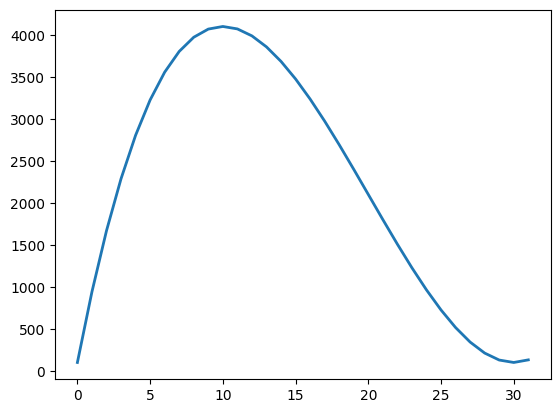

In [149]:
x = np.arange(32)
y = np.array(list(map(cubic_function, x)))

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

# ax.set(xlim=(0, 32), xticks=np.arange(0, 32),
#        ylim=(0, 5000), yticks=np.arange(0, 5000))

plt.show()

In [150]:
#def cubic_function(x):
#    x = int(''.join(str(c) for c in x), 2)
#    return (x, x**3 - 60*x**2 + 900*x + 100)


In [151]:
sa = SAnnealing(domain=((0, 32),), step=1, final_temperature=0.1, temperature=500, alpha=0.95, equilibrium=10, time=0)
sa.fit(cubic_function)


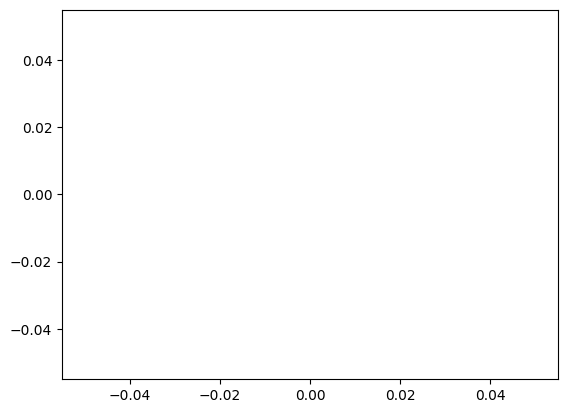

In [152]:
plt.plot(range(len(sa.cost_)), [x[1] for x in sa.cost_ ])
plt.show()

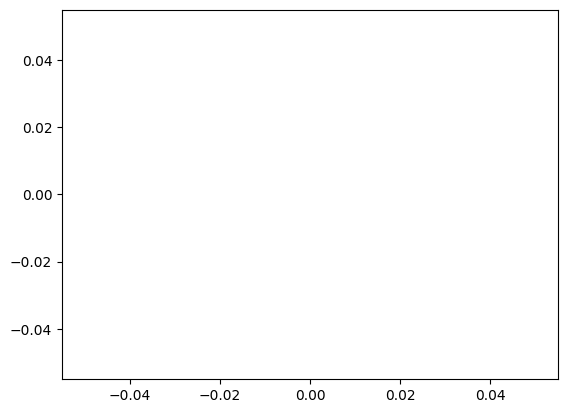

In [153]:
plt.plot(range(len(sa.cost_)), [x[0] for x in sa.cost_ ])
plt.show()

In [154]:
sa = SAnnealing(domain=((0, 32),), step=1, final_temperature=0.1, temperature=200, alpha=0.95, equilibrium=10, time=0)
sa.fit(cubic_function)

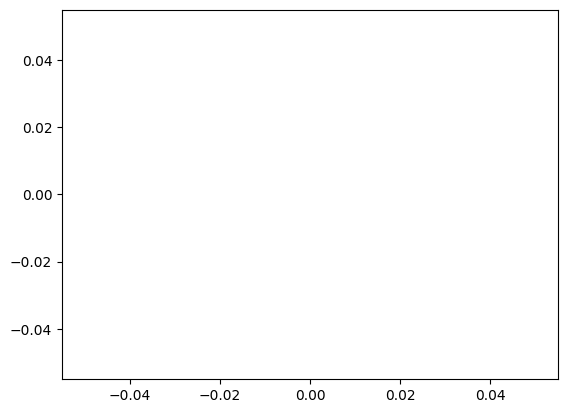

In [155]:
plt.plot(range(len(sa.cost_)), [x[1] for x in sa.cost_ ])
plt.show()

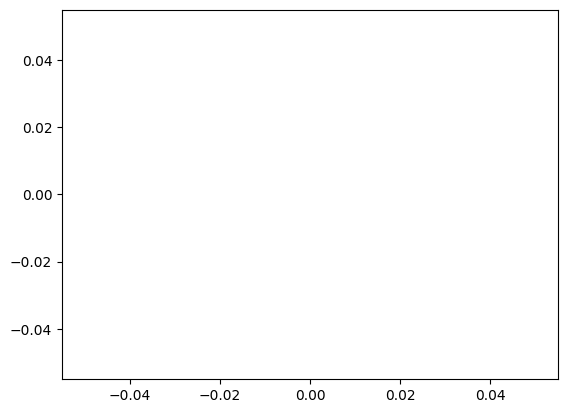

In [156]:
plt.plot(range(len(sa.cost_)), [x[0] for x in sa.cost_ ])
plt.show()